In [1]:
from __future__ import annotations

import shutil
from pathlib import Path
from tempfile import TemporaryDirectory

import geopandas as gpd
import pywbt
import rioxarray as rxr

import seamless_3dep as sdem

In [2]:
url = "https://reference.geoconnex.us/collections/hu08/items/10190005"
vrain = gpd.read_file(url).to_crs(4326).union_all()

Skipping field hucs: unsupported OGR type: 5


In [15]:
data_dir = Path("data")
tiff_files = sdem.get(vrain.bounds, data_dir)

In [16]:
if len(tiff_files) == 1:
    dem_file = tiff_files[0]
else:
    dem_file = data_dir / "dem_vrain_3dep.vrt"
    sdem.build_vrt(dem_file, tiff_files)
dem = rxr.open_rasterio(dem_file).squeeze(drop=True)
dem.size

43732600

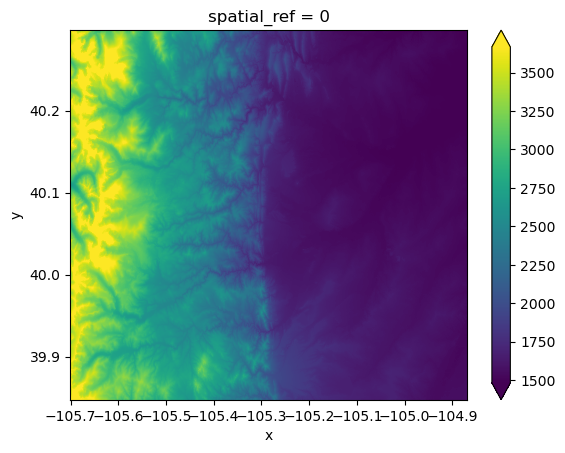

In [17]:
ax = dem.plot.imshow(robust=True)
ax.figure.savefig("images/dem.png")

In [12]:
twi_files = [data_dir / fname.name.replace("dem", "twi") for fname in tiff_files]
slope_files = [data_dir / fname.name.replace("dem", "slope") for fname in tiff_files]
for dname, tname, sname in zip(tiff_files, twi_files, slope_files, strict=False):
    with TemporaryDirectory(dir=data_dir) as temp:
        shutil.copy(dname, temp)
        wbt_args = {
            "BreachDepressions": [f"-i={dname.name}", "--fill_pits", "-o=dem_corr.tiff"],
            "D8Pointer": ["-i=dem_corr.tiff", "-o=fdir.tiff"],
            "D8FlowAccumulation": [
                "-i=fdir.tiff",
                "--pntr",
                "--out_type='specific contributing area'",
                "-o=sca.tiff",
            ],
            "Slope": ["-i=dem_corr.tiff", "--units=degrees", f"-o={sname.name}"],
            "WetnessIndex": ["--sca=sca.tiff", f"--slope={sname.name}", f"-o={tname.name}"],
        }
        pywbt.whitebox_tools(temp, wbt_args, [sname.name, tname.name], temp)
        shutil.copy(Path(temp) / tname.name, data_dir)
        shutil.copy(Path(temp) / sname.name, data_dir)
twi_vrt = data_dir / "twi_vrain_3dep.vrt"
sdem.build_vrt(twi_vrt, twi_files)
slope_vrt = data_dir / "slope_vrain_3dep.vrt"
sdem.build_vrt(slope_vrt, slope_files)

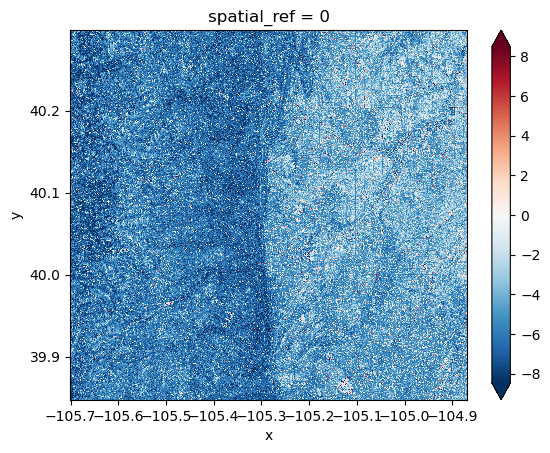

In [13]:
twi = rxr.open_rasterio(twi_vrt).squeeze(drop=True)
ax = twi.plot.imshow(robust=True)
ax.figure.savefig("images/twi.png")

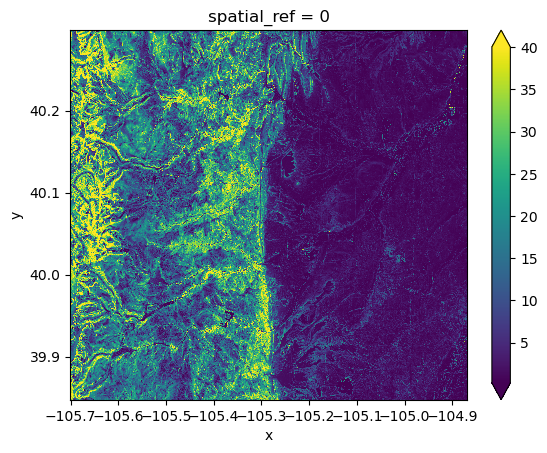

In [14]:
slope = rxr.open_rasterio(slope_vrt).squeeze(drop=True)
ax = slope.plot.imshow(robust=True)
ax.figure.savefig("images/slope.png")